In [1]:

"""
=============================================================================
PEC4 - BREAST CANCER WISCONSIN DATASET
Autor: David Roldán Martínez
Asignatura: Minería de Datos - Programa de Doctorado en Sistemas Inteligentes
Tema: Bagging y Métodos Ensemble
=============================================================================
"""

# =============================================================================
# CELDA 1: IMPORTACIÓN DE LIBRERÍAS Y CONFIGURACIÓN
# =============================================================================
# Descripción: Importación de todas las librerías necesarias para el análisis,
# modelado y visualización. Se fija semilla aleatoria para reproducibilidad.



# Forzamos la actualización de los pilares del stack para evitar conflictos con SHAP y SciKeras
!pip install --upgrade scikit-learn scikeras numpy shap ucimlrepo

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Dataset
!pip install ucimlrepo

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, confusion_matrix,
                             classification_report, ConfusionMatrixDisplay)

# Deep Learning
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier

# Explicabilidad
import shap

from ucimlrepo import fetch_ucirepo

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Semilla para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ Librerías importadas correctamente")
print(f"✓ Semilla aleatoria fijada: {RANDOM_STATE}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 29.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
✓ Librerías importadas correctamente
✓ Semilla aleatoria fijada: 42


In [2]:
# =============================================================================
# CELDA 2: CARGA Y ESTRUCTURACIÓN DEL DATASET
# =============================================================================
# Descripción: Carga del Breast Cancer Wisconsin (Diagnostic) Dataset desde
# UCI ML Repository. Se construye el DataFrame completo y se verifica integridad.

# Carga del dataset
breast_cancer = fetch_ucirepo(id=17)

# Extracción de features y target
X = breast_cancer.data.features
y = breast_cancer.data.targets

# Construcción del DataFrame completo
df = pd.DataFrame(X, columns=breast_cancer.feature_names)
df['diagnosis'] = y.values.flatten()

print("="*80)
print("INFORMACIÓN DEL DATASET")
print("="*80)
print(f"\n📊 Dimensiones: {df.shape[0]} instancias × {df.shape[1]} variables")
print(f"📋 Variables predictoras: {X.shape[1]}")
print(f"🎯 Variable objetivo: {y.columns[0]}")
print(f"\n🔍 Distribución de clases:")
print(df['diagnosis'].value_counts())
print(f"\n📈 Proporción de clases:")
print(df['diagnosis'].value_counts(normalize=True))
print(f"\n✓ Valores perdidos totales: {df.isnull().sum().sum()}")
print("\n" + "="*80)

# Visualización de información estructural
df.info()

INFORMACIÓN DEL DATASET

📊 Dimensiones: 569 instancias × 31 variables
📋 Variables predictoras: 30
🎯 Variable objetivo: Diagnosis

🔍 Distribución de clases:
diagnosis
B    357
M    212
Name: count, dtype: int64

📈 Proporción de clases:
diagnosis
B    0.627417
M    0.372583
Name: proportion, dtype: float64

✓ Valores perdidos totales: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   radius1             569 non-null    float64
 1   texture1            569 non-null    float64
 2   perimeter1          569 non-null    float64
 3   area1               569 non-null    float64
 4   smoothness1         569 non-null    float64
 5   compactness1        569 non-null    float64
 6   concavity1          569 non-null    float64
 7   concave_points1     569 non-null    float64
 8   symmetry1           569 non-null    float64
 9   fractal_dimen

In [3]:
# =============================================================================
# CELDA 3: ANÁLISIS EXPLORATORIO DE DATOS (EDA) - ESTADÍSTICA DESCRIPTIVA
# =============================================================================
# Descripción: Cálculo de estadísticos descriptivos completos incluyendo
# medidas de tendencia central, dispersión, asimetría y curtosis.

# Estadísticos descriptivos completos
desc_stats = df.drop('diagnosis', axis=1).describe().T
desc_stats['skewness'] = df.drop('diagnosis', axis=1).skew()
desc_stats['kurtosis'] = df.drop('diagnosis', axis=1).kurtosis()
desc_stats['IQR'] = desc_stats['75%'] - desc_stats['25%']

# Selección de variables representativas para reporte
selected_vars = ['radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1',
                 'compactness1', 'concavity1', 'concave_points1']

print("\n" + "="*80)
print("ESTADÍSTICOS DESCRIPTIVOS - VARIABLES REPRESENTATIVAS")
print("="*80)
print(desc_stats.loc[selected_vars, ['mean', '50%', 'std', 'skewness', 'kurtosis', 'IQR']].round(4))
print("="*80)

# Interpretación automática
high_skew = desc_stats[desc_stats['skewness'] > 1.0]
print(f"\n📊 Variables con asimetría alta (>1.0): {len(high_skew)}")
print(high_skew[['mean', 'skewness']].round(3))


ESTADÍSTICOS DESCRIPTIVOS - VARIABLES REPRESENTATIVAS
                     mean       50%       std  skewness  kurtosis       IQR
radius1           14.1273   13.3700    3.5240    0.9424    0.8455    4.0800
texture1          19.2896   18.8400    4.3010    0.6504    0.7583    5.6300
perimeter1        91.9690   86.2400   24.2990    0.9907    0.9722   28.9300
area1            654.8891  551.1000  351.9141    1.6457    3.6523  362.4000
smoothness1        0.0964    0.0959    0.0141    0.4563    0.8560    0.0189
compactness1       0.1043    0.0926    0.0528    1.1901    1.6501    0.0655
concavity1         0.0888    0.0615    0.0797    1.4012    1.9986    0.1011
concave_points1    0.0489    0.0335    0.0388    1.1712    1.0666    0.0537

📊 Variables con asimetría alta (>1.0): 22
                       mean  skewness
area1               654.889     1.646
compactness1          0.104     1.190
concavity1            0.089     1.401
concave_points1       0.049     1.171
fractal_dimension1    0.063 

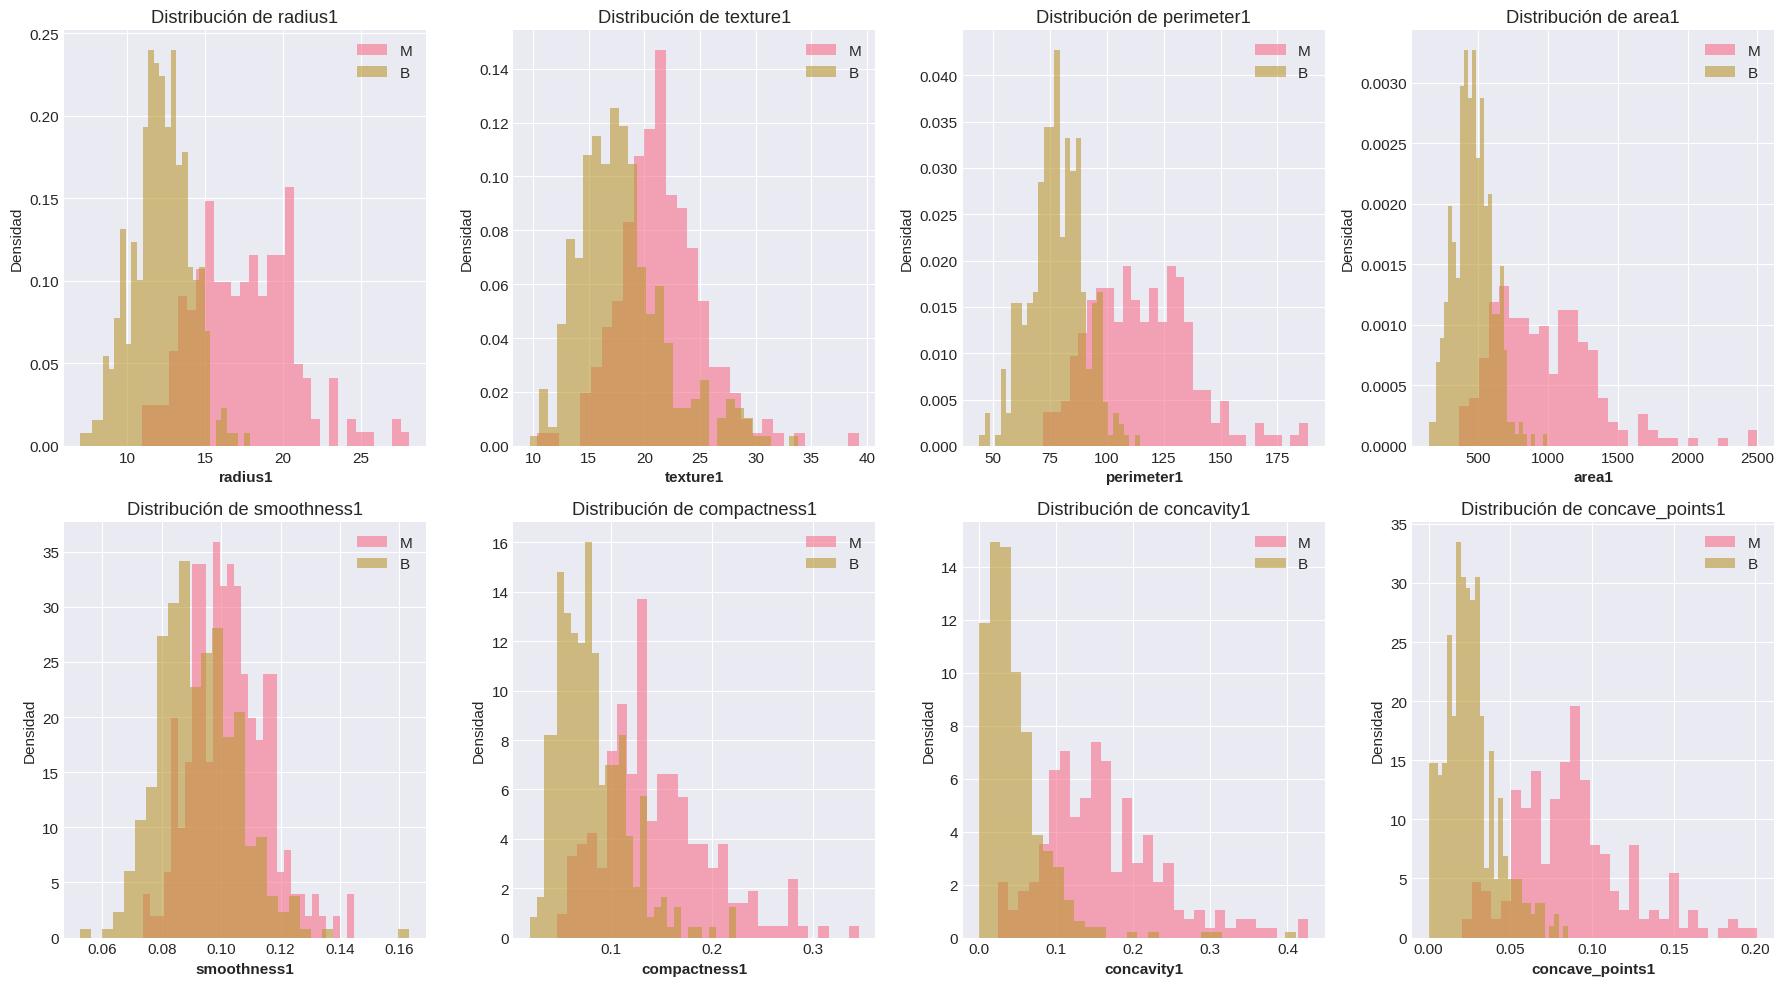

✓ Figura 1 generada: Distribuciones por diagnóstico


In [4]:
# =============================================================================
# CELDA 4: VISUALIZACIÓN I - DISTRIBUCIONES Y RELACIÓN CON TARGET
# =============================================================================
# Descripción: Generación de visualizaciones para entender distribuciones
# univariadas y su relación con la variable objetivo (diagnóstico).

# Codificación temporal para visualización
df_viz = df.copy()
label_encoder = LabelEncoder()
df_viz['diagnosis_encoded'] = label_encoder.fit_transform(df_viz['diagnosis'])

# Figura 1: Distribuciones de variables clave con separación por diagnóstico
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.ravel()

key_features = ['radius1', 'texture1', 'perimeter1', 'area1',
                'smoothness1', 'compactness1', 'concavity1', 'concave_points1']

for idx, feature in enumerate(key_features):
    for diagnosis in df_viz['diagnosis'].unique():
        subset = df_viz[df_viz['diagnosis'] == diagnosis][feature]
        axes[idx].hist(subset, alpha=0.6, bins=30, label=diagnosis, density=True)

    axes[idx].set_xlabel(feature, fontweight='bold')
    axes[idx].set_ylabel('Densidad')
    axes[idx].legend()
    axes[idx].set_title(f'Distribución de {feature}')

plt.tight_layout()
plt.savefig('mejora_distribucion_variables.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figura 1 generada: Distribuciones por diagnóstico")

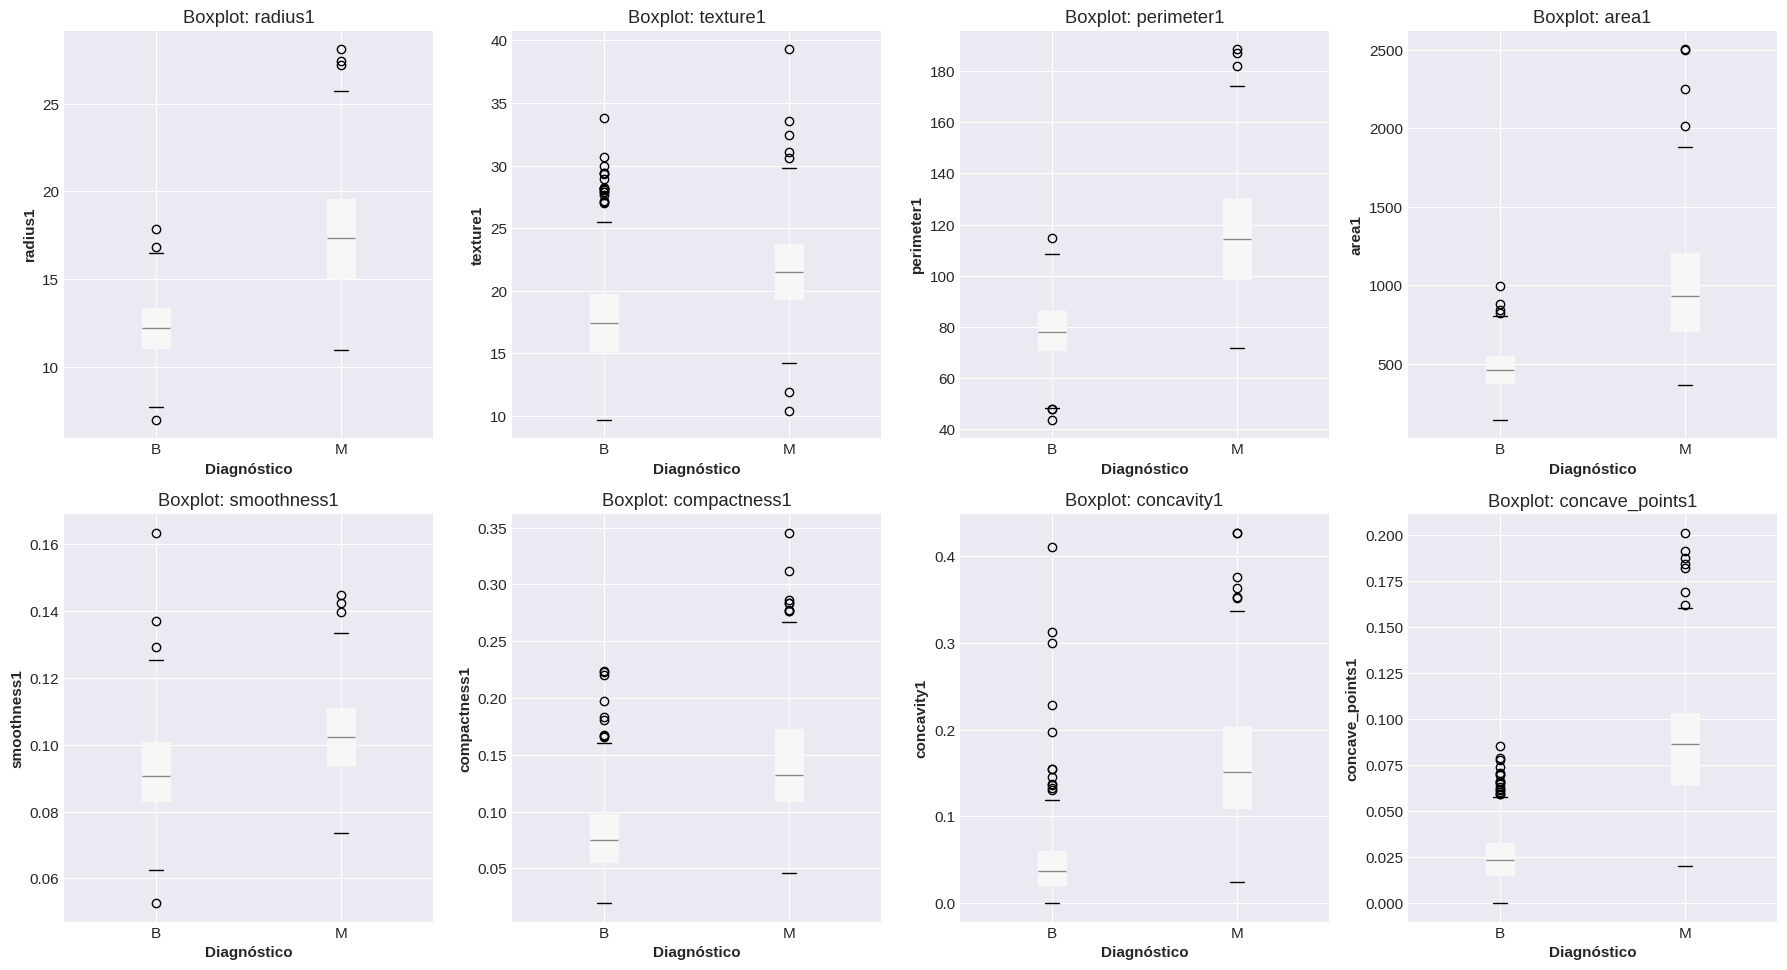

✓ Figura 2 generada: Boxplots para detección de outliers


In [5]:
# =============================================================================
# CELDA 5: VISUALIZACIÓN II - BOXPLOTS PARA DETECCIÓN DE OUTLIERS
# =============================================================================
# Descripción: Boxplots que permiten identificar valores atípicos en variables
# clave, especialmente aquellas relacionadas con tamaño tumoral.

fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.ravel()

for idx, feature in enumerate(key_features):
    df_viz.boxplot(column=feature, by='diagnosis', ax=axes[idx], patch_artist=True)
    axes[idx].set_xlabel('Diagnóstico', fontweight='bold')
    axes[idx].set_ylabel(feature, fontweight='bold')
    axes[idx].set_title(f'Boxplot: {feature}')
    axes[idx].get_figure().suptitle('')  # Eliminar título automático

plt.tight_layout()
plt.savefig('mejora_boxplots_outliers.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figura 2 generada: Boxplots para detección de outliers")

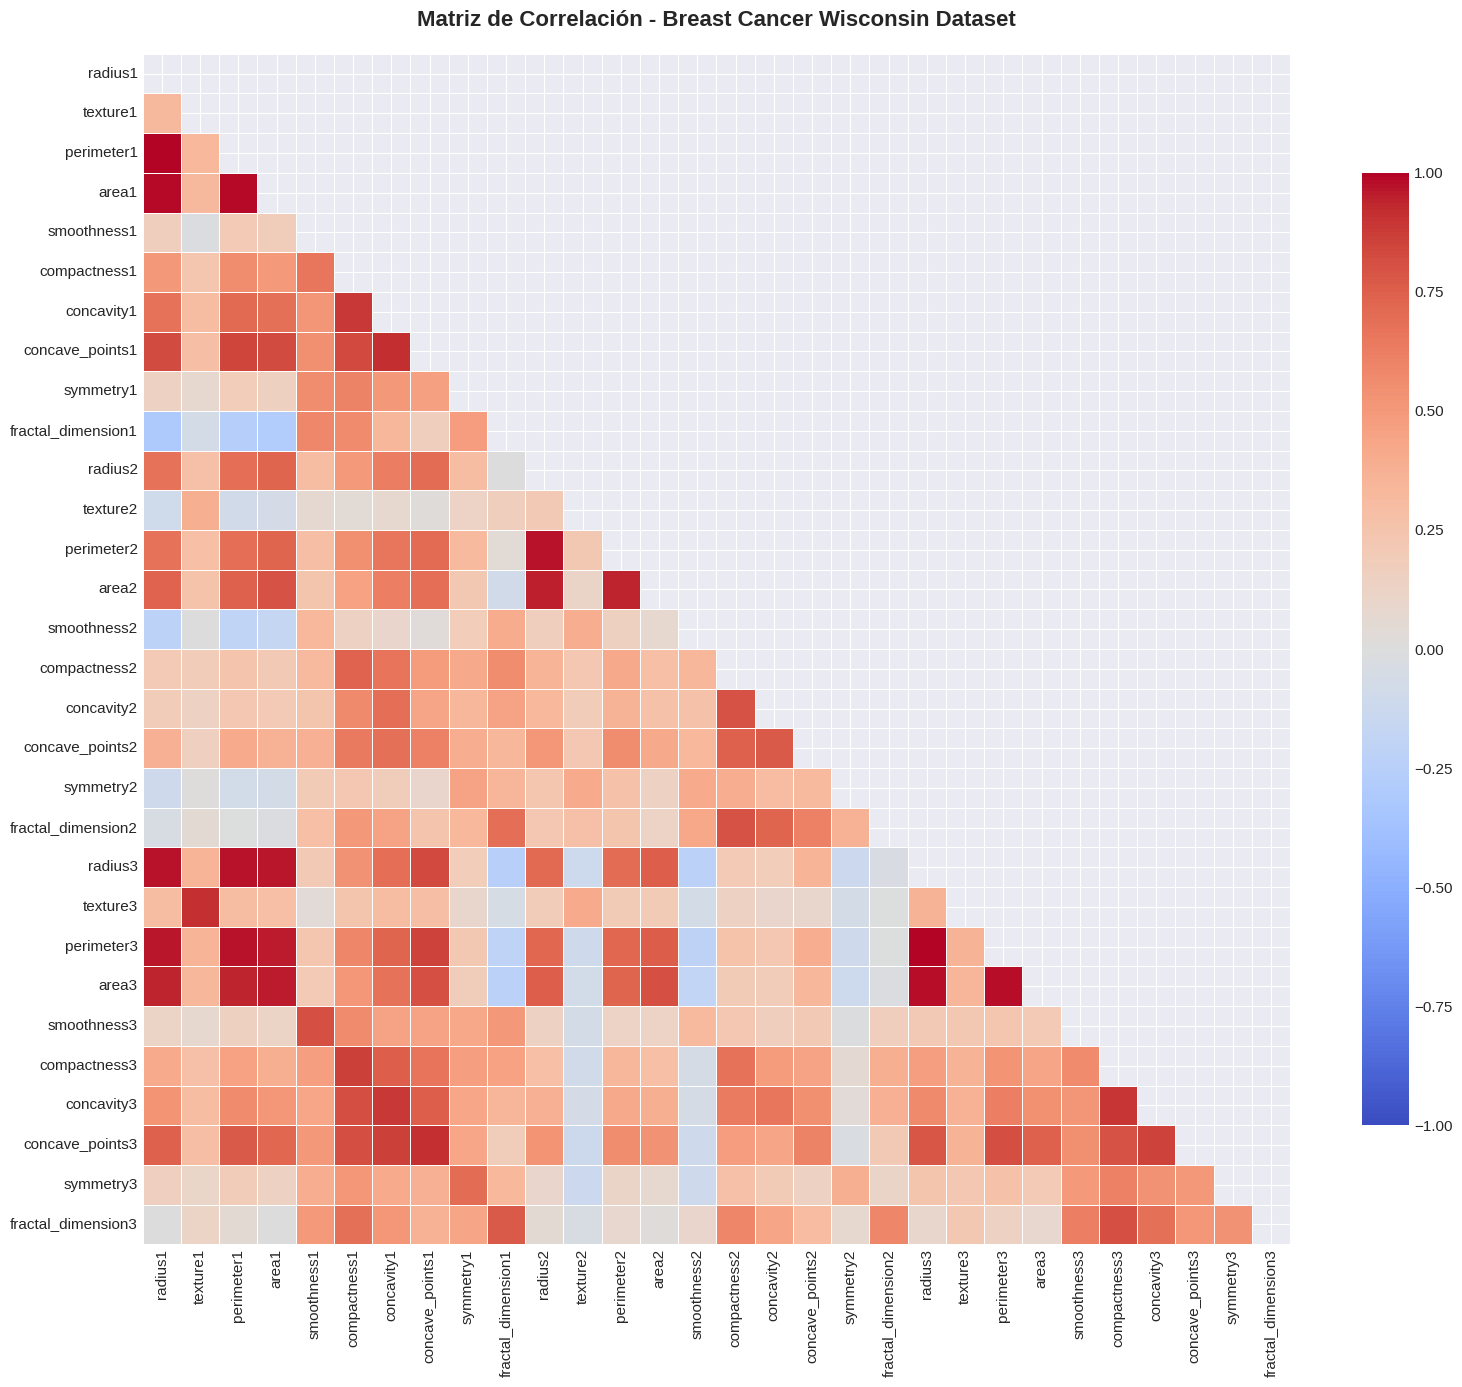


CORRELACIONES ALTAS (|r| > 0.9)
     Variable 1      Variable 2  Correlación
        radius1      perimeter1     0.997855
        radius3      perimeter3     0.993708
        radius1           area1     0.987357
     perimeter1           area1     0.986507
        radius3           area3     0.984015
     perimeter3           area3     0.977578
        radius2      perimeter2     0.972794
     perimeter1      perimeter3     0.970387
        radius1         radius3     0.969539
     perimeter1         radius3     0.969476
        radius1      perimeter3     0.965137
          area1         radius3     0.962746
          area1           area3     0.959213
          area1      perimeter3     0.959120
        radius2           area2     0.951830
     perimeter1           area3     0.941550
        radius1           area3     0.941082
     perimeter2           area2     0.937655
     concavity1 concave_points1     0.921391
       texture1        texture3     0.912045
concave_points1 concav

In [6]:
# =============================================================================
# CELDA 6: VISUALIZACIÓN III - MATRIZ DE CORRELACIÓN
# =============================================================================
# Descripción: Heatmap de correlación de Pearson para identificar
# multicolinealidad entre variables predictoras.

# Cálculo de matriz de correlación
correlation_matrix = df.drop('diagnosis', axis=1).corr()

# Visualización con heatmap
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm',
            center=0, vmin=-1, vmax=1, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación - Breast Cancer Wisconsin Dataset',
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('mejora_correlacion_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Identificación de correlaciones altas
high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            high_corr.append({
                'Variable 1': correlation_matrix.columns[i],
                'Variable 2': correlation_matrix.columns[j],
                'Correlación': correlation_matrix.iloc[i, j]
            })

high_corr_df = pd.DataFrame(high_corr).sort_values('Correlación', ascending=False)
print("\n" + "="*80)
print("CORRELACIONES ALTAS (|r| > 0.9)")
print("="*80)
print(high_corr_df.to_string(index=False))
print("="*80)
print(f"\n✓ Total de pares con correlación > 0.9: {len(high_corr_df)}")

In [7]:
# =============================================================================
# CELDA 7: PREPROCESAMIENTO - CODIFICACIÓN Y PARTICIÓN ESTRATIFICADA
# =============================================================================
# Descripción: Codificación de la variable objetivo (M=1, B=0) y división
# estratificada del dataset en conjuntos de entrenamiento (80%) y prueba (20%).

# Codificación de la variable objetivo
# M (Maligno) = 1, B (Benigno) = 0
y_encoded = label_encoder.fit_transform(y)
print("\n" + "="*80)
print("CODIFICACIÓN DE VARIABLE OBJETIVO")
print("="*80)
print(f"Mapeo: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")
print("="*80)

# Partición estratificada 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_encoded
)

print(f"\n📊 Conjunto de entrenamiento: {X_train.shape[0]} instancias")
print(f"📊 Conjunto de prueba: {X_test.shape[0]} instancias")
print(f"\n✓ Distribución de clases en entrenamiento:")
print(pd.Series(y_train).value_counts(normalize=True))
print(f"\n✓ Distribución de clases en prueba:")
print(pd.Series(y_test).value_counts(normalize=True))

# Escalado para modelos sensibles (SVM, MLP)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Escalado aplicado (StandardScaler) para SVM y MLP")


CODIFICACIÓN DE VARIABLE OBJETIVO
Mapeo: {'B': np.int64(0), 'M': np.int64(1)}

📊 Conjunto de entrenamiento: 455 instancias
📊 Conjunto de prueba: 114 instancias

✓ Distribución de clases en entrenamiento:
0    0.626374
1    0.373626
Name: proportion, dtype: float64

✓ Distribución de clases en prueba:
0    0.631579
1    0.368421
Name: proportion, dtype: float64

✓ Escalado aplicado (StandardScaler) para SVM y MLP


In [8]:
# =============================================================================
# CELDA 8: MODELADO - DEFINICIÓN DE MODELOS BASE
# =============================================================================
# Descripción: Inicialización de todos los modelos a evaluar, incluyendo
# CART, Bagging, Random Forest, SVM y MLP (añadido como mejora crítica).

# Modelos basados en árboles (sin escalado)
cart = DecisionTreeClassifier(random_state=RANDOM_STATE)

bagging_dt = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
    n_estimators=100,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

random_forest = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Modelo baseline no lineal (con escalado)
svm = SVC(
    kernel='rbf',
    probability=True,
    random_state=RANDOM_STATE
)

# MLP - MEJORA CRÍTICA AÑADIDA
def create_mlp(input_dim=30):
    """
    Crea arquitectura MLP para clasificación binaria.

    Arquitectura:
    - Capa de entrada: 30 features
    - Capa oculta 1: 64 neuronas, ReLU, Dropout 0.3
    - Capa oculta 2: 32 neuronas, ReLU, Dropout 0.3
    - Capa de salida: 1 neurona, Sigmoid
    """
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu',
                    kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu',
                    kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )

    return model

# Wrapper de Keras para compatibilidad con scikit-learn
mlp = KerasClassifier(
    model=create_mlp,
    epochs=100,
    batch_size=32,
    verbose=0,
    random_state=RANDOM_STATE
)

print("="*80)
print("MODELOS INICIALIZADOS")
print("="*80)
print("✓ CART (Decision Tree)")
print("✓ Bagging con Decision Trees (n_estimators=100)")
print("✓ Random Forest (n_estimators=100)")
print("✓ SVM con kernel RBF")
print("✓ MLP (Keras): [64-Dropout-32-Dropout-1] con L2 regularization")
print("="*80)

MODELOS INICIALIZADOS
✓ CART (Decision Tree)
✓ Bagging con Decision Trees (n_estimators=100)
✓ Random Forest (n_estimators=100)
✓ SVM con kernel RBF
✓ MLP (Keras): [64-Dropout-32-Dropout-1] con L2 regularization


In [9]:
# =============================================================================
# CELDA 9: ENTRENAMIENTO Y EVALUACIÓN EN CONJUNTO DE PRUEBA
# =============================================================================
# Descripción: Entrenamiento de todos los modelos y evaluación en el conjunto
# de prueba independiente. Se calculan todas las métricas relevantes.

# Diccionario de modelos y sus respectivos datos
models = {
    'CART': (cart, X_train, X_test),
    'Bagging_DT': (bagging_dt, X_train, X_test),
    'RandomForest': (random_forest, X_train, X_test),
    'SVM': (svm, X_train_scaled, X_test_scaled),
    'MLP': (mlp, X_train_scaled, X_test_scaled)
}

# Almacenamiento de resultados
results = []
roc_data = {}

print("\n" + "="*80)
print("ENTRENAMIENTO Y EVALUACIÓN DE MODELOS")
print("="*80)

for name, (model, X_tr, X_te) in models.items():
    print(f"\n🔄 Entrenando {name}...")

    # Entrenamiento
    if name == 'MLP':
        # Early stopping para MLP
        early_stop = EarlyStopping(monitor='loss', patience=10,
                                   restore_best_weights=True, verbose=0)
        model.fit(X_tr, y_train,
                 validation_split=0.2,
                 callbacks=[early_stop],
                 verbose=0)
    else:
        model.fit(X_tr, y_train)

    # Predicciones
    y_pred = model.predict(X_te)

    # Probabilidades para ROC-AUC
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_te)[:, 1]
    elif name == 'MLP':
        y_proba = model.predict(X_te).ravel()
    else:
        y_proba = y_pred

    # Cálculo de métricas
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    }

    results.append(metrics)

    # Almacenar datos para curvas ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_data[name] = (fpr, tpr, metrics['ROC-AUC'])

    print(f"   ✓ {name} completado")

# Crear DataFrame de resultados
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('ROC-AUC', ascending=False)

print("\n" + "="*80)
print("TABLA 4 (MEJORADA): RENDIMIENTO COMPARATIVO DE LOS MODELOS")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)


ENTRENAMIENTO Y EVALUACIÓN DE MODELOS

🔄 Entrenando CART...
   ✓ CART completado

🔄 Entrenando Bagging_DT...
   ✓ Bagging_DT completado

🔄 Entrenando RandomForest...
   ✓ RandomForest completado

🔄 Entrenando SVM...
   ✓ SVM completado

🔄 Entrenando MLP...
   ✓ MLP completado

TABLA 4 (MEJORADA): RENDIMIENTO COMPARATIVO DE LOS MODELOS
       Model  Accuracy  Precision   Recall  F1-score  ROC-AUC
         MLP  0.982456   1.000000 0.952381  0.975610 0.995370
         SVM  0.973684   1.000000 0.928571  0.962963 0.994709
RandomForest  0.973684   1.000000 0.928571  0.962963 0.992890
  Bagging_DT  0.973684   1.000000 0.928571  0.962963 0.991071
        CART  0.929825   0.904762 0.904762  0.904762 0.924603


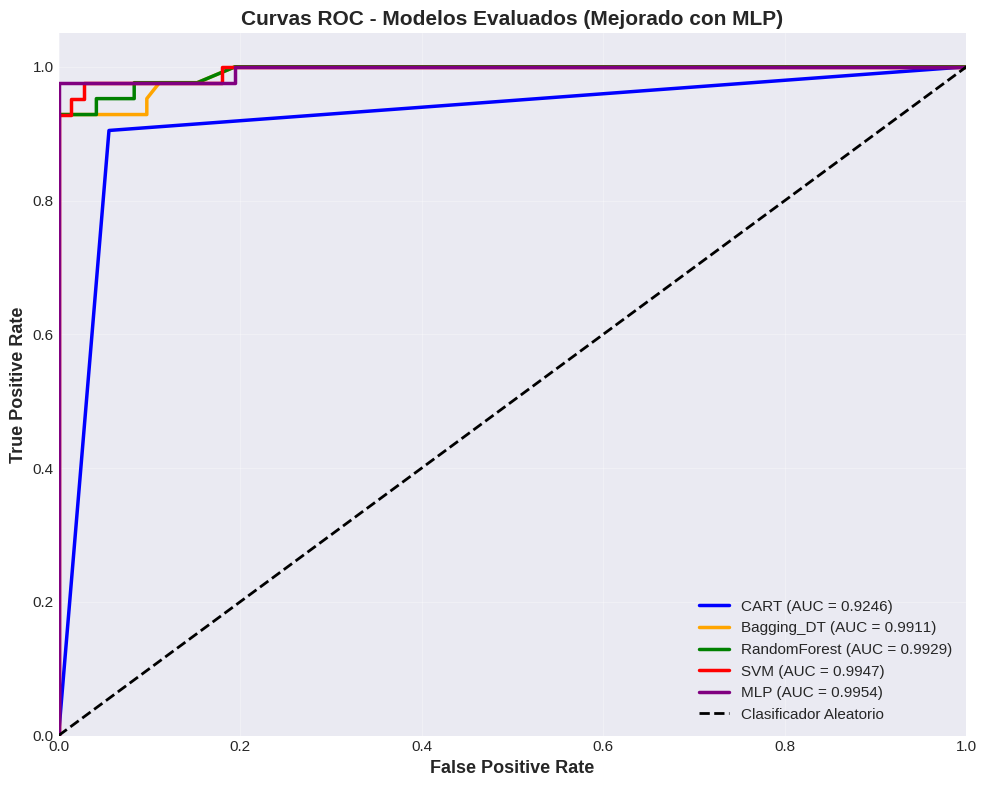

✓ Figura 3 (mejorada) generada: Curvas ROC incluyendo MLP


In [10]:
# =============================================================================
# CELDA 10: VISUALIZACIÓN DE CURVAS ROC (MEJORADA)
# =============================================================================
# Descripción: Generación de curvas ROC para todos los modelos evaluados,
# incluyendo el MLP ausente en la versión original.

plt.figure(figsize=(10, 8))

colors = ['blue', 'orange', 'green', 'red', 'purple']
for (name, (fpr, tpr, auc)), color in zip(roc_data.items(), colors):
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})',
             linewidth=2.5, color=color)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Clasificador Aleatorio')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
plt.title('Curvas ROC - Modelos Evaluados (Mejorado con MLP)',
          fontsize=15, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('mejora_curvas_roc.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figura 3 (mejorada) generada: Curvas ROC incluyendo MLP")

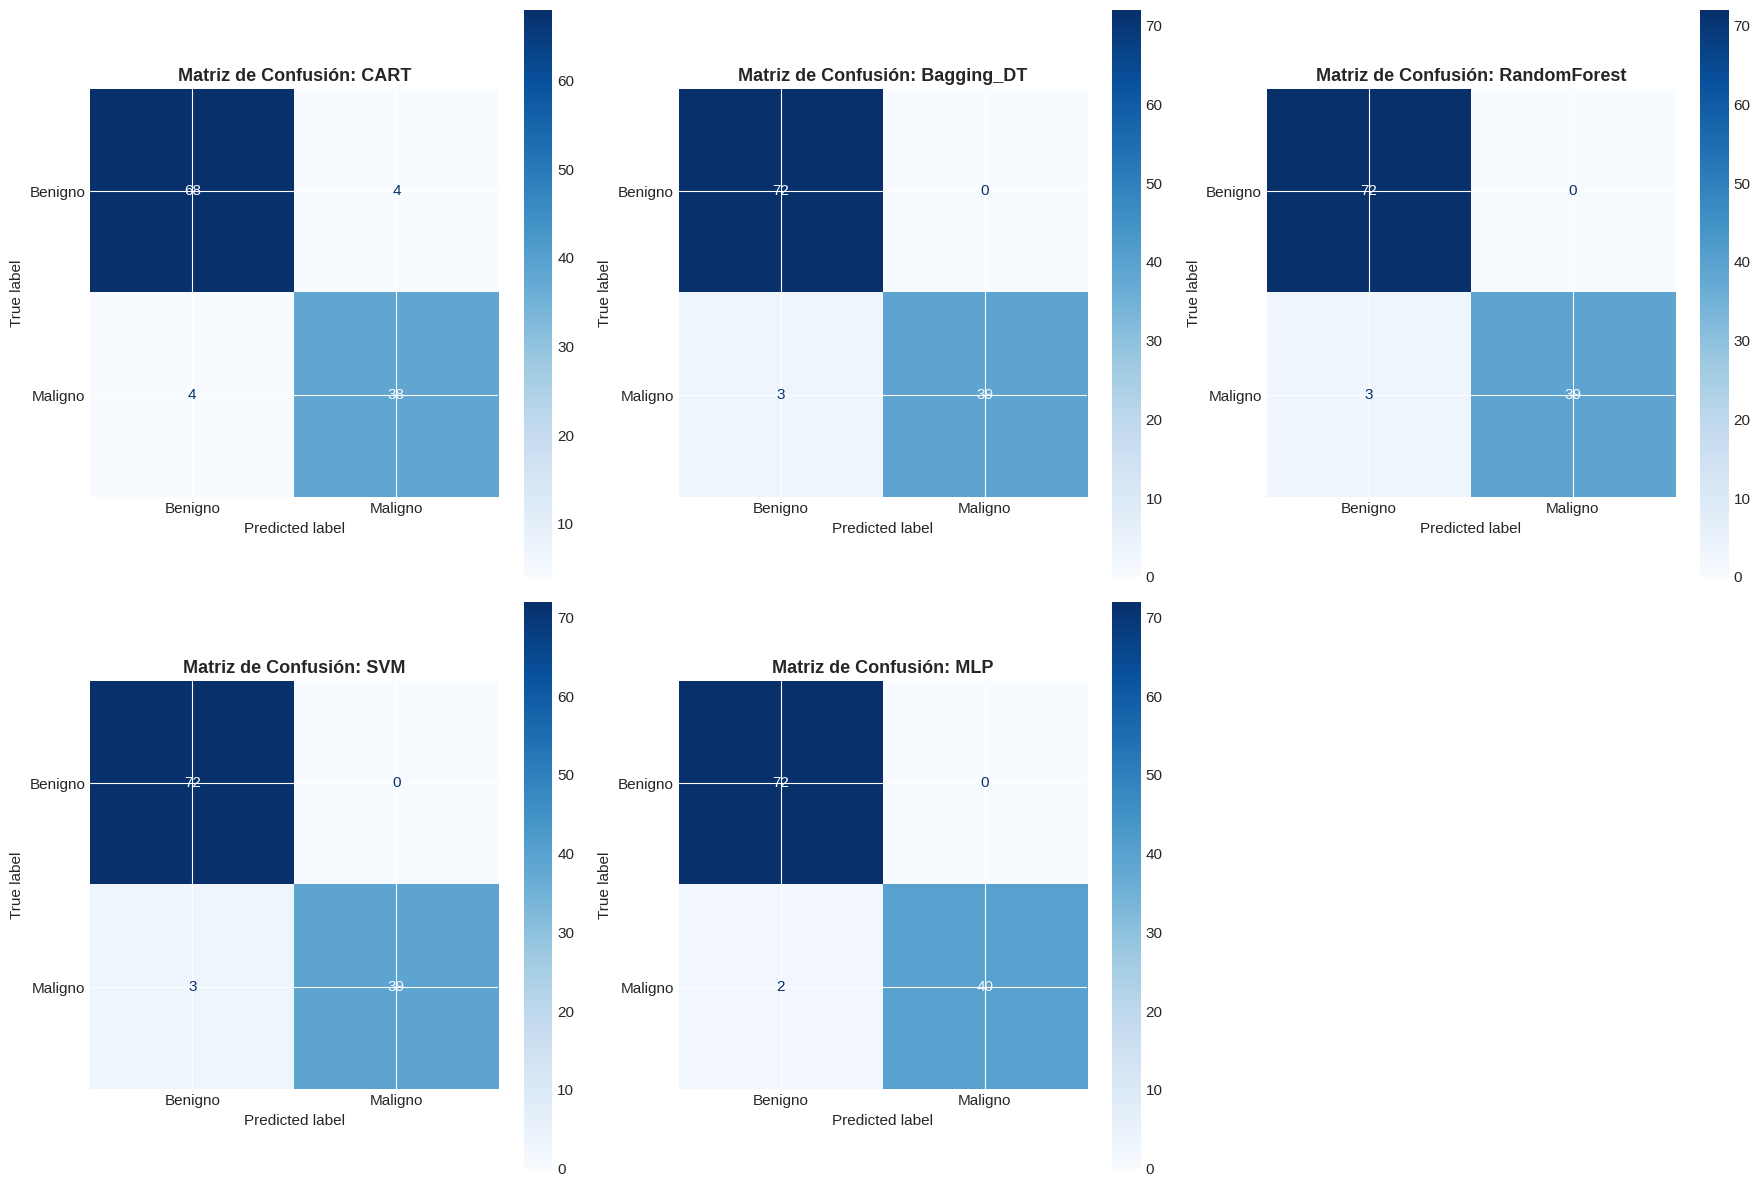

✓ Figura 4 generada: Matrices de confusión para análisis de errores


In [11]:
# =============================================================================
# CELDA 11: MATRICES DE CONFUSIÓN
# =============================================================================
# Descripción: Visualización de matrices de confusión para analizar el tipo
# de errores cometidos por cada modelo (FP vs FN).

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, (name, (model, X_tr, X_te)) in enumerate(models.items()):
    y_pred = model.predict(X_te)
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                   display_labels=['Benigno', 'Maligno'])
    disp.plot(ax=axes[idx], cmap='Blues', values_format='d')
    axes[idx].set_title(f'Matriz de Confusión: {name}',
                       fontsize=13, fontweight='bold')

# Eliminar eje extra
axes[-1].remove()

plt.tight_layout()
plt.savefig('mejora_matrices_confusion.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figura 4 generada: Matrices de confusión para análisis de errores")

In [12]:
# =============================================================================
# CELDA 12: VALIDACIÓN CRUZADA ESTRATIFICADA - MEJORA CRÍTICA
# =============================================================================
# Descripción: Validación cruzada estratificada 5-fold para estimar
# rendimiento robusto con intervalos de confianza.

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

cv_results = []

print("\n" + "="*80)
print("VALIDACIÓN CRUZADA ESTRATIFICADA (5-FOLD)")
print("="*80)

for name, (model, X_tr, _) in models.items():
    print(f"\n🔄 Evaluando {name} con validación cruzada...")

    # Set n_jobs based on model type (KerasClassifier has issues with n_jobs=-1 in cross_validate)
    n_jobs_for_cv = 1 if name == 'MLP' else -1

    # Realizar validación cruzada
    cv_scores = cross_validate(
        model, X_tr, y_train,
        cv=cv_strategy,
        scoring=scoring,
        n_jobs=n_jobs_for_cv, # Use n_jobs=1 for MLP, -1 for others
        return_train_score=False
    )

    # Calcular estadísticos
    cv_result = {
        'Model': name,
        'Accuracy': f"{cv_scores['test_accuracy'].mean():.6f} ± {cv_scores['test_accuracy'].std():.6f}",
        'Precision': f"{cv_scores['test_precision'].mean():.6f} ± {cv_scores['test_precision'].std():.6f}",
        'Recall': f"{cv_scores['test_recall'].mean():.6f} ± {cv_scores['test_recall'].std():.6f}",
        'F1-score': f"{cv_scores['test_f1'].mean():.6f} ± {cv_scores['test_f1'].std():.6f}",
        'ROC-AUC': f"{cv_scores['test_roc_auc'].mean():.6f} ± {cv_scores['test_roc_auc'].std():.6f}"
    }

    cv_results.append(cv_result)
    print(f"   ✓ {name} completado")

# Crear DataFrame de validación cruzada
cv_results_df = pd.DataFrame(cv_results)

print("\n" + "="*80)
print("TABLA 5 (GENERADA): RESULTADOS DE VALIDACIÓN CRUZADA ESTRATIFICADA")
print("="*80)
print(cv_results_df.to_string(index=False))
print("="*80)


VALIDACIÓN CRUZADA ESTRATIFICADA (5-FOLD)

🔄 Evaluando CART con validación cruzada...
   ✓ CART completado

🔄 Evaluando Bagging_DT con validación cruzada...
   ✓ Bagging_DT completado

🔄 Evaluando RandomForest con validación cruzada...
   ✓ RandomForest completado

🔄 Evaluando SVM con validación cruzada...
   ✓ SVM completado

🔄 Evaluando MLP con validación cruzada...


   ✓ MLP completado

TABLA 5 (GENERADA): RESULTADOS DE VALIDACIÓN CRUZADA ESTRATIFICADA
       Model            Accuracy           Precision              Recall            F1-score             ROC-AUC
        CART 0.923077 ± 0.032599 0.899593 ± 0.040582 0.894118 ± 0.060563 0.896184 ± 0.044707 0.917234 ± 0.037542
  Bagging_DT 0.962637 ± 0.022628 0.959205 ± 0.037153 0.941176 ± 0.037203 0.949562 ± 0.030179 0.984056 ± 0.011978
RandomForest 0.964835 ± 0.014579 0.964095 ± 0.010688 0.941176 ± 0.041595 0.951945 ± 0.020732 0.988906 ± 0.006734
         SVM 0.971429 ± 0.005383 0.976946 ± 0.021035 0.947059 ± 0.034300 0.960987 ± 0.008203 0.994840 ± 0.004650
         MLP 0.982418 ± 0.008791 0.983175 ± 0.022304 0.970588 ± 0.032219 0.976186 ± 0.012382           nan ± nan


In [14]:
# =============================================================================
# CELDA 13: OPTIMIZACIÓN DE HIPERPARÁMETROS - RANDOM FOREST
# =============================================================================
# Descripción: Búsqueda aleatoria de hiperparámetros para Random Forest
# usando RandomizedSearchCV con validación cruzada.

print("\n" + "="*80)
print("OPTIMIZACIÓN DE HIPERPARÁMETROS: RANDOM FOREST")
print("="*80)

# Espacio de búsqueda
param_dist_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features':['sqrt', 'log2'],
'bootstrap': [True, False]
}

# Random Search
random_search_rf = RandomizedSearchCV(
RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
param_distributions=param_dist_rf,
n_iter=50,
cv=cv_strategy,
scoring='roc_auc',
n_jobs=-1,
random_state=RANDOM_STATE,
verbose=1
)
print("\n🔍 Iniciando búsqueda aleatoria (50 iteraciones)...")
random_search_rf.fit(X_train, y_train)
print("\n✓ Optimización completada")
print(f"\n📊 Mejores hiperparámetros encontrados:")
for param, value in random_search_rf.best_params_.items():
  print(f"   • {param}: {value}")
print(f"\n📈 Mejor ROC-AUC en validación cruzada: {random_search_rf.best_score_:.6f}")

# Evaluación en conjunto de prueba
best_rf = random_search_rf.best_estimator_
y_pred_best = best_rf.predict(X_test)
y_proba_best = best_rf.predict_proba(X_test)[:, 1]
print(f"\n📊 Rendimiento en conjunto de prueba:")
print(f"   • Accuracy: {accuracy_score(y_test, y_pred_best):.6f}")
print(f"   • ROC-AUC: {roc_auc_score(y_test, y_proba_best):.6f}")


OPTIMIZACIÓN DE HIPERPARÁMETROS: RANDOM FOREST

🔍 Iniciando búsqueda aleatoria (50 iteraciones)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

✓ Optimización completada

📊 Mejores hiperparámetros encontrados:
   • n_estimators: 50
   • min_samples_split: 5
   • min_samples_leaf: 1
   • max_features: log2
   • max_depth: 20
   • bootstrap: False

📈 Mejor ROC-AUC en validación cruzada: 0.989835

📊 Rendimiento en conjunto de prueba:
   • Accuracy: 0.964912
   • ROC-AUC: 0.994378


In [15]:
# =============================================================================
# CELDA 14: OPTIMIZACIÓN DE HIPERPARÁMETROS - BAGGING
# =============================================================================
# Descripción: Búsqueda en cuadrícula para Bagging con Decision Trees.

print("\n" + "="*80)
print("OPTIMIZACIÓN DE HIPERPARÁMETROS: BAGGING")
print("="*80)

# Espacio de búsqueda
param_grid_bagging = {
    'n_estimators': [50, 100, 150, 200],
    'max_samples': [0.5, 0.7, 0.9, 1.0],
    'max_features': [0.5, 0.7, 0.9, 1.0],
    'bootstrap': [True, False]
}

# Grid Search
grid_search_bagging = GridSearchCV(
    BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    param_grid=param_grid_bagging,
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("\n🔍 Iniciando búsqueda en cuadrícula...")
grid_search_bagging.fit(X_train, y_train)

print("\n✓ Optimización completada")
print(f"\n📊 Mejores hiperparámetros encontrados:")
for param, value in grid_search_bagging.best_params_.items():
    print(f"   • {param}: {value}")

print(f"\n📈 Mejor ROC-AUC en validación cruzada: {grid_search_bagging.best_score_:.6f}")

# Evaluación en conjunto de prueba
best_bagging = grid_search_bagging.best_estimator_
y_pred_best_bag = best_bagging.predict(X_test)
y_proba_best_bag = best_bagging.predict_proba(X_test)[:, 1]

print(f"\n📊 Rendimiento en conjunto de prueba:")
print(f"   • Accuracy: {accuracy_score(y_test, y_pred_best_bag):.6f}")
print(f"   • ROC-AUC: {roc_auc_score(y_test, y_proba_best_bag):.6f}")


OPTIMIZACIÓN DE HIPERPARÁMETROS: BAGGING

🔍 Iniciando búsqueda en cuadrícula...
Fitting 5 folds for each of 128 candidates, totalling 640 fits

✓ Optimización completada

📊 Mejores hiperparámetros encontrados:
   • bootstrap: True
   • max_features: 0.7
   • max_samples: 0.7
   • n_estimators: 100

📈 Mejor ROC-AUC en validación cruzada: 0.989938

📊 Rendimiento en conjunto de prueba:
   • Accuracy: 0.973684
   • ROC-AUC: 0.991071



EXPLICABILIDAD CON SHAP

🔄 Calculando valores SHAP (puede tardar varios minutos)...
✓ Valores SHAP calculados correctamente


<Figure size 1200x800 with 0 Axes>

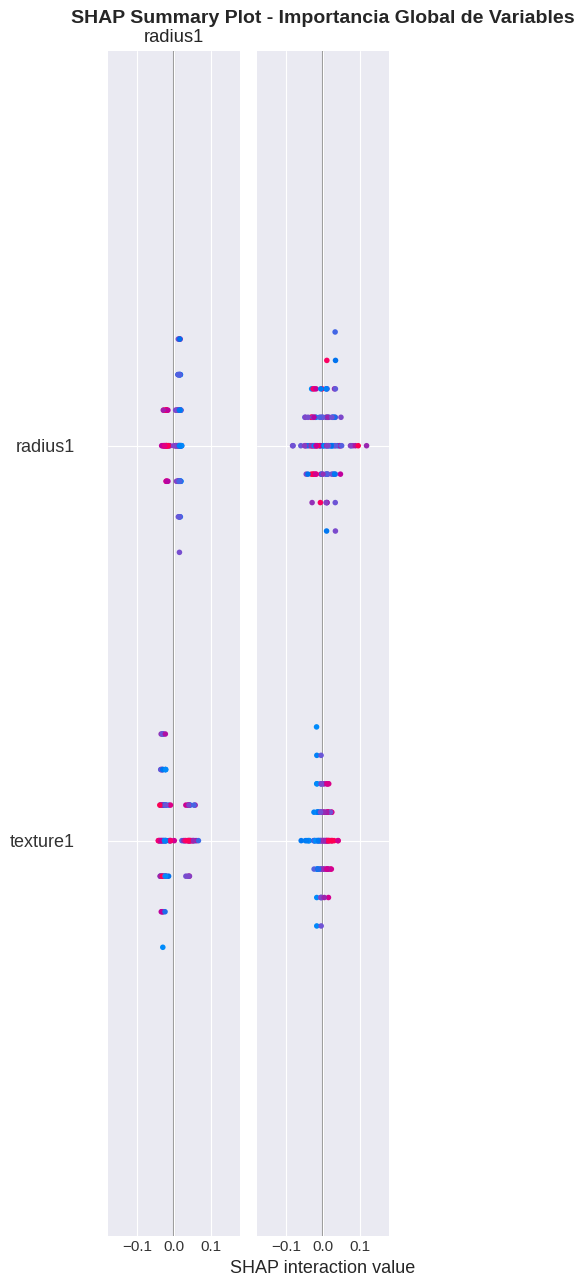

✓ Figura 5 generada: SHAP Summary Plot


<Figure size 1000x800 with 0 Axes>

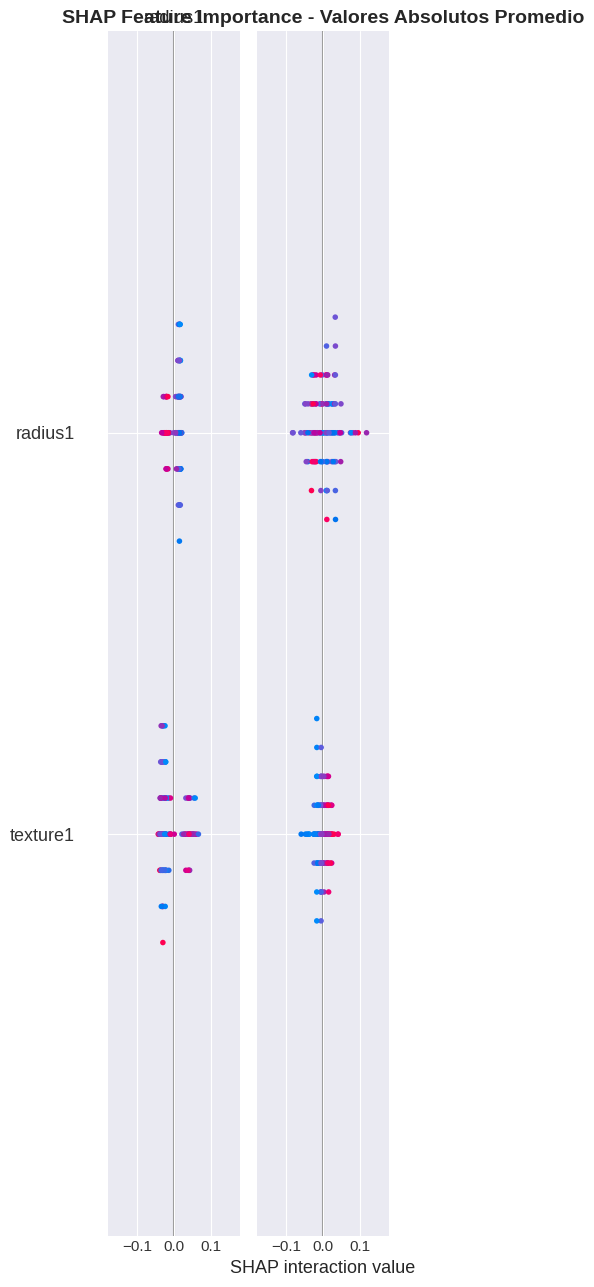

✓ Figura 6 generada: SHAP Feature Importance


In [16]:
# =============================================================================
# CELDA 15: EXPLICABILIDAD CON SHAP - MEJORA CRÍTICA
# =============================================================================
# Descripción: Aplicación de SHAP (SHapley Additive exPlanations) para
# interpretación global y local del mejor modelo Random Forest optimizado.

print("\n" + "="*80)
print("EXPLICABILIDAD CON SHAP")
print("="*80)

# Usar el Random Forest optimizado
print("\n🔄 Calculando valores SHAP (puede tardar varios minutos)...")

# Crear explicador SHAP
explainer = shap.TreeExplainer(best_rf)

# Calcular valores SHAP para conjunto de prueba
shap_values = explainer.shap_values(X_test)

# Si devuelve lista (clasificación binaria), tomar clase positiva
if isinstance(shap_values, list):
    shap_values_positive = shap_values[1]
else:
    shap_values_positive = shap_values

print("✓ Valores SHAP calculados correctamente")

# 1. Summary Plot (importancia global)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_positive, X_test,
                  feature_names=breast_cancer.feature_names,
                  show=False, max_display=15)
plt.title('SHAP Summary Plot - Importancia Global de Variables',
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('mejora_shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figura 5 generada: SHAP Summary Plot")

# 2. Bar Plot (importancia media absoluta)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_positive, X_test,
                  feature_names=breast_cancer.feature_names,
                  plot_type='bar', show=False, max_display=15)
plt.title('SHAP Feature Importance - Valores Absolutos Promedio',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('mejora_shap_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figura 6 generada: SHAP Feature Importance")

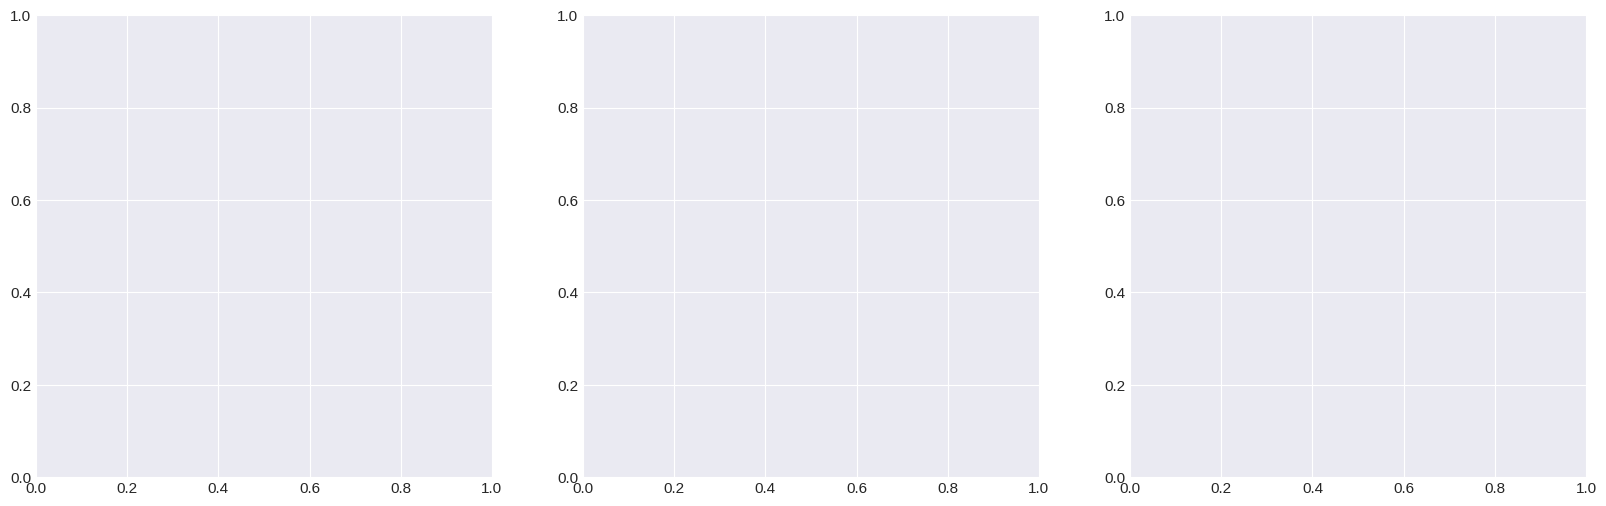

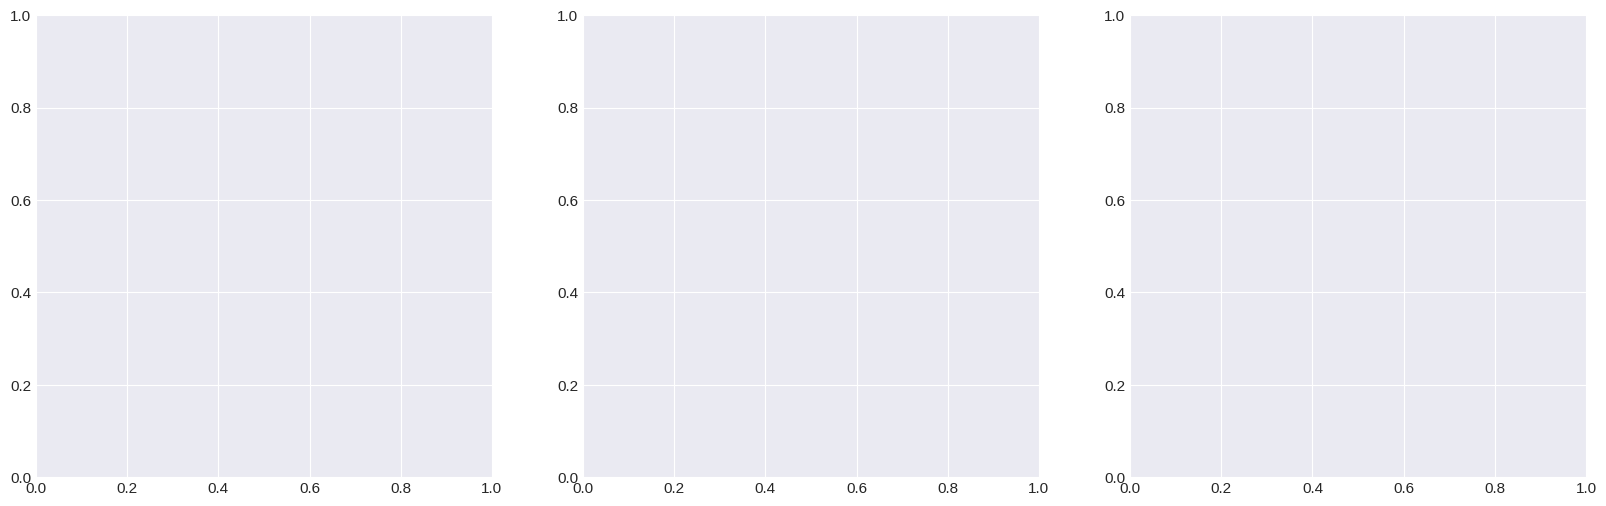

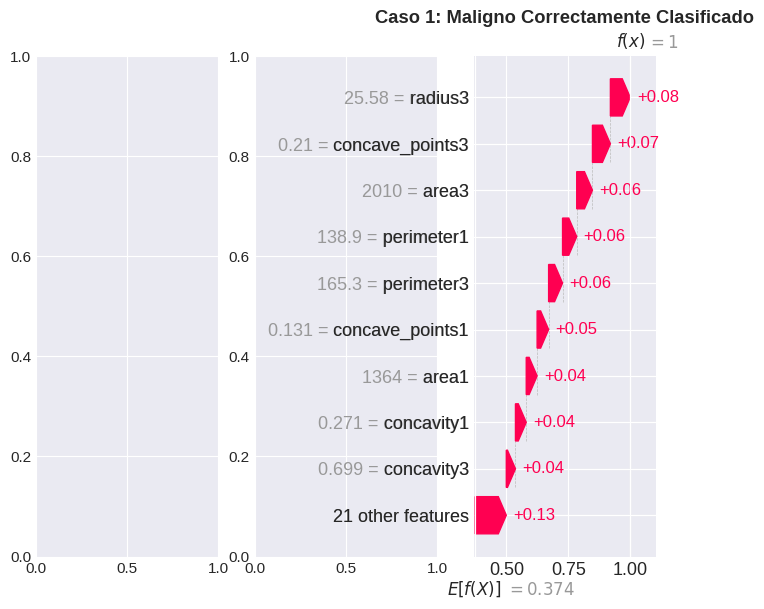

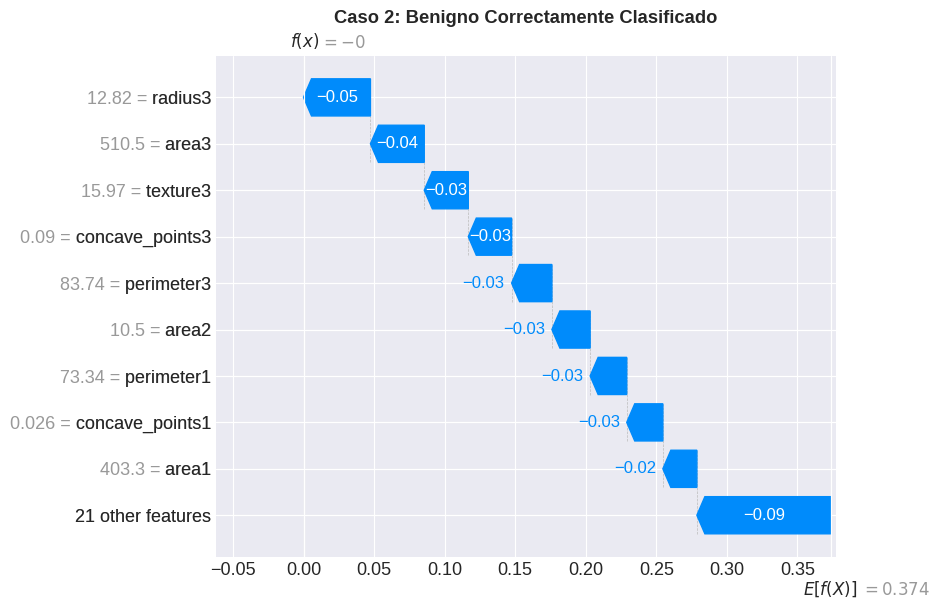

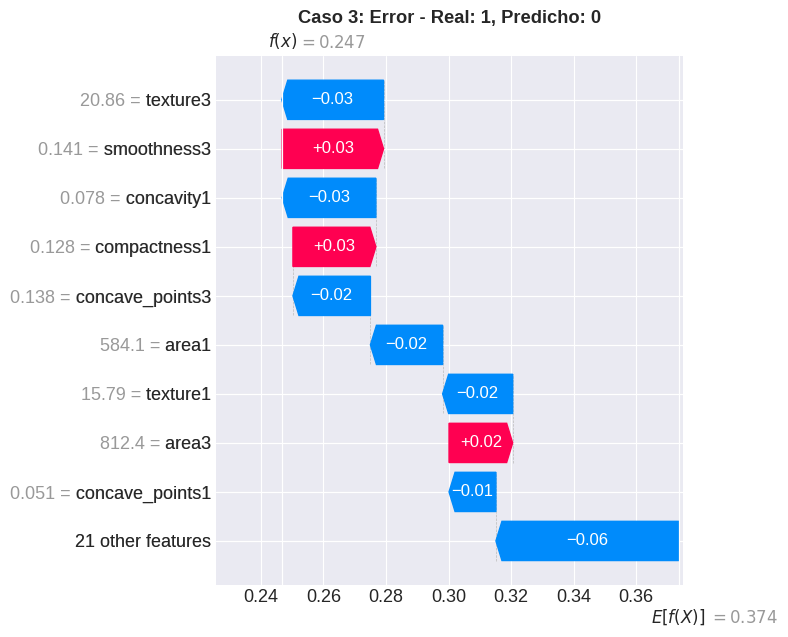

✓ Figura 7 generada: SHAP Waterfall Plots para análisis local


In [20]:
# =============================================================================
# CELDA 16: EXPLICABILIDAD LOCAL CON SHAP - CASOS ESPECÍFICOS
# =============================================================================
# Descripción: Análisis de predicciones individuales mediante waterfall plots
# para casos correctamente clasificados y errores del modelo.

# Identificar casos de interés
correct_predictions = (y_pred_best == y_test)
malignant_cases = (y_test == 1)

# Caso 1: Maligno correctamente clasificado
correct_malignant_idx = np.where(correct_predictions & malignant_cases)[0][0]

# Caso 2: Benigno correctamente clasificado
benign_cases = (y_test == 0)
correct_benign_idx = np.where(correct_predictions & benign_cases)[0][0]

# Caso 3: Error (si existe)
error_indices = np.where(~correct_predictions)[0]
if len(error_indices) > 0:
    error_idx = error_indices[0]
    has_error = True
else:
    has_error = False
    print("⚠️ No hay errores en el conjunto de prueba")

# Re-derivar shap_values_for_plot for this cell to ensure correct shape for waterfall plots
# This addresses the ValueError where a matrix (30, 2) was passed instead of a vector (30,)
# When shap_values from TreeExplainer is a 3D array (samples, features, classes),
# we need to select the SHAP values for the positive class (index 1).
if isinstance(shap_values, list):
    shap_values_for_plot_local = shap_values[1]
else:
    shap_values_for_plot_local = shap_values[:, :, 1]

# Visualización de casos
fig, axes = plt.subplots(1, 3 if has_error else 2, figsize=(20, 6))

# Caso 1: Maligno correcto
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_for_plot_local[correct_malignant_idx], # Use the correctly shaped values
        base_values=explainer.expected_value[1], # Fixed: Directly access base value for positive class
        data=X_test.iloc[correct_malignant_idx],
        feature_names=breast_cancer.feature_names
    ),
    show=False
)
plt.title('Caso 1: Maligno Correctamente Clasificado', fontweight='bold')
axes[0] = plt.gca()

# Caso 2: Benigno correcto
plt.figure()
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_for_plot_local[correct_benign_idx], # Use the correctly shaped values
        base_values=explainer.expected_value[1], # Fixed: Directly access base value for positive class
        data=X_test.iloc[correct_benign_idx],
        feature_names=breast_cancer.feature_names
    ),
    show=False
)
plt.title('Caso 2: Benigno Correctamente Clasificado', fontweight='bold')

# Caso 3: Error (si existe)
if has_error:
    plt.figure()
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values_for_plot_local[error_idx], # Use the correctly shaped values
            base_values=explainer.expected_value[1], # Fixed: Directly access base value for positive class
            data=X_test.iloc[error_idx],
            feature_names=breast_cancer.feature_names
        ),
        show=False
    )
    plt.title(f'Caso 3: Error - Real: {y_test[error_idx]}, Predicho: {y_pred_best[error_idx]}',
              fontweight='bold')

plt.tight_layout()
plt.savefig('mejora_shap_local.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Figura 7 generada: SHAP Waterfall Plots para análisis local")